In [269]:
import sys
import gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import unittest 
from IPython.display import Markdown, display

from collections import defaultdict, deque
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random

## Part I : Environment Creation

In [6]:
env = gym.make('Blackjack-v1')

In [7]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [30]:
## plot Blackjack
def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

In [29]:
def run_check(check_name, func):
    try:
        getattr(check, check_name)(func)
    except check.failureException as e:
        printmd('**<span style="color: red;">PLEASE TRY AGAIN</span>**')
        return
    printmd('**<span style="color: green;">PASSED</span>**')

In [246]:
def win_draw_rate(all_scores):    
    b = pd.DataFrame(list(all_scores),columns=['score'])
    b['win'] = np.where(b['score']==1.0,1.0,0)
    b['draw'] = np.where(b['score']==0.0,1.0,0)
    b['episode'] = b.index +1
    b['win_rate'] = (b['win'].cumsum()/b['episode'])*100
    b['draw_rate'] = (b['draw'].cumsum()/b['episode'])*100
    return b

## Part II : Agent Development
### I. Q-Learning

In [24]:
def epsilon_greedy(Q, state, nA, eps):
    if random.random() > eps: 
        return np.argmax(Q[state])
    else:                     
        return random.choice(np.arange(env.action_space.n))

In [207]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    current = Q[state][action]  
    Qsa_next = np.max(Q[next_state]) if next_state is not None else 0  
    target = reward + (gamma * Qsa_next)               
    new_value = current + (alpha * (target - current)) 
    return new_value

def q_learning(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    nA = env.action_space.n                
    Q = defaultdict(lambda: np.zeros(nA))  
    tmp_scores = deque(maxlen=plot_every)     
    avg_scores = deque(maxlen=num_episodes)   
    all_scores = deque(maxlen=num_episodes)  
    for i_episode in range(1, num_episodes+1):
        
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        score = 0                                              
        state = env.reset()                                    
        eps = 1.0 / i_episode                                  
        
        while True:
            action = epsilon_greedy(Q, state, nA, eps)         
            next_state, reward, done, info = env.step(action)  
            score += reward                                    
            Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, \
                                                 state, action, reward, next_state)        
            state = next_state                                 
            if done:
                tmp_scores.append(score)                       
                all_scores.append(score)
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
    
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return policy, Q, all_scores

### II. State–action–reward–state–action (SARSA)

In [188]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    current = Q[state][action]  
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0    
    target = reward + (gamma * Qsa_next)               
    new_value = current + (alpha * (target - current)) 
    return new_value
def sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    nA = env.action_space.n               
    Q = defaultdict(lambda: np.zeros(nA))  
    tmp_scores = deque(maxlen=plot_every)     
    avg_scores = deque(maxlen=num_episodes)   
    all_scores = deque(maxlen=num_episodes)
    
    for i_episode in range(1, num_episodes+1):
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        score = 0                                           
        state = env.reset()                                   
        
        eps = 1.0 / i_episode                                 
        action = epsilon_greedy(Q, state, nA, eps)            
        
        while True:
            next_state, reward, done, info = env.step(action) 
            score += reward                                   
            if not done:
                next_action = epsilon_greedy(Q, next_state, nA, eps) 
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward, next_state, next_action)
                
                state = next_state     
                action = next_action   
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
                tmp_scores.append(score)    
                all_scores.append(score)
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))    
    return policy,Q,all_scores

### III. Expexted SARSA

In [210]:
def update_Q_expsarsa(alpha, gamma, nA, eps, Q, state, action, reward, next_state=None):
    current = Q[state][action]         
    policy_s = np.ones(nA) * eps / nA 
    policy_s[np.argmax(Q[next_state])] = 1 - eps + (eps / nA) 
    Qsa_next = np.dot(Q[next_state], policy_s)         
    target = reward + (gamma * Qsa_next)               
    new_value = current + (alpha * (target - current)) 
    return new_value
def expected_sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    nA = env.action_space.n               
    Q = defaultdict(lambda: np.zeros(nA))  

    tmp_scores = deque(maxlen=plot_every)     
    avg_scores = deque(maxlen=num_episodes)   
    all_scores = deque(maxlen=num_episodes)
    
    for i_episode in range(1, num_episodes+1):
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()       
        score = 0            
        state = env.reset()   
        eps = 0.005           
        
        while True:
            action = epsilon_greedy(Q, state, nA, eps)         
            next_state, reward, done, info = env.step(action)  
            score += reward                                    
            Q[state][action] = update_Q_expsarsa(alpha, gamma, nA, eps, Q, \
                                                 state, action, reward, next_state)        
            state = next_state             
            if done:
                tmp_scores.append(score)    
                all_scores.append(score)
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return policy,Q,all_scores

### IV. Monte Carlo Exploring Start (ES)

In [213]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0,plot_every=100):
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    tmp_scores = deque(maxlen=plot_every)     
    avg_scores = deque(maxlen=num_episodes)
    all_scores = deque(maxlen=num_episodes)
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        score = 0            
        episode = []
        state = env.reset()
        while True:
            probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
            action = np.random.choice(np.arange(2), p=probs)
            next_state, reward, done, info = env.step(action)
            score += reward   
            episode.append((state, action, reward))
            state = next_state
            if done:
                tmp_scores.append(score) 
                all_scores.append(score)
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]

    policy = dict((k,np.argmax(v)) for k, v in Q.items())

    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return policy,Q,all_scores

### IV. Monte Carlo Control

In [217]:
def get_probs(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05,plot_every=100):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    
    tmp_scores = deque(maxlen=plot_every)    
    avg_scores = deque(maxlen=num_episodes)
    all_scores = deque(maxlen=num_episodes)
    
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        epsilon = max(epsilon*eps_decay, eps_min)
        score = 0            
        episode = []
        state = env.reset()
        while True:
            action = np.random.choice(np.arange(nA), 
                                      p=get_probs(Q[state], epsilon, nA)) if state in Q else env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            score += reward 
            episode.append((state, action, reward))
            state = next_state
            if done:
                tmp_scores.append(score)  
                all_scores.append(score)
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))

        Q = update_Q(env, episode, Q, alpha, gamma)
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return policy, Q,all_scores

## PART III : Exploratory Data Analysis
### I. Q-Learning

Episode 500000/500000

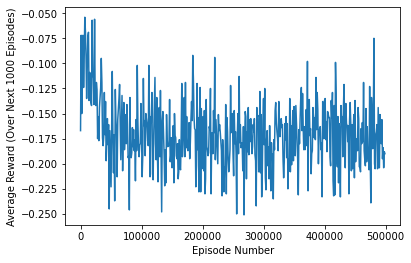

Best Average Reward over 1000 Episodes:  -0.054


In [270]:
policy_Q,Q_learning,score_Q = q_learning(env, 500000, .01,plot_every=1000)

In [248]:
Q_score = win_draw_rate(score_Q)

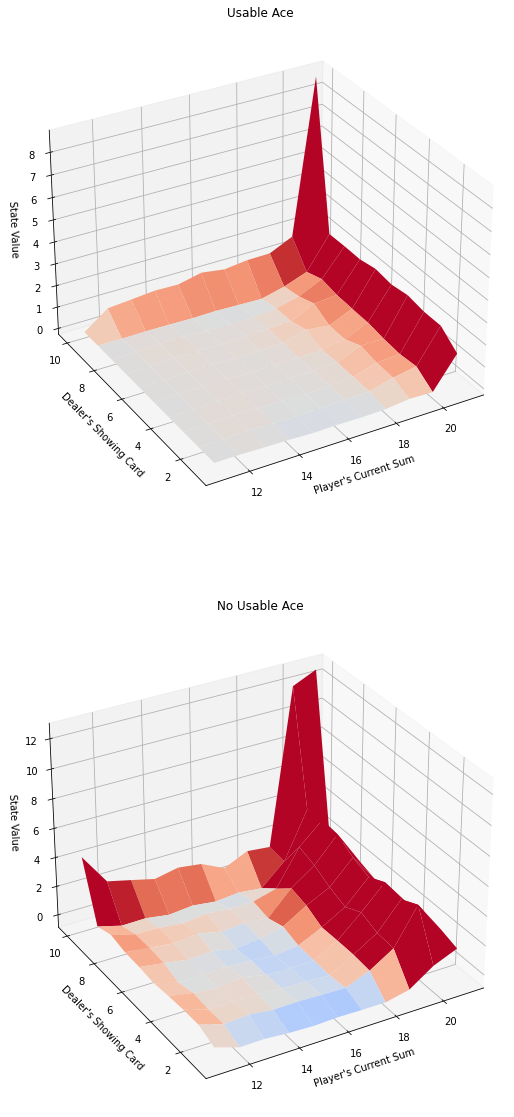

In [52]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q_learning .items())

# plot the state-value function
plot_blackjack_values(V)

### II. State–action–reward–state–action (SARSA)

Episode 500000/500000

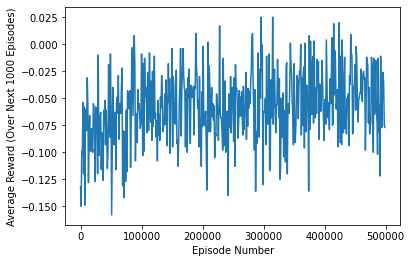

Best Average Reward over 1000 Episodes:  0.025


In [271]:
policy_sarsa,Q_sarsa,score_sarsa = sarsa(env, 500000, .01,plot_every=1000)

In [250]:
sarsa_score = win_draw_rate(score_sarsa)

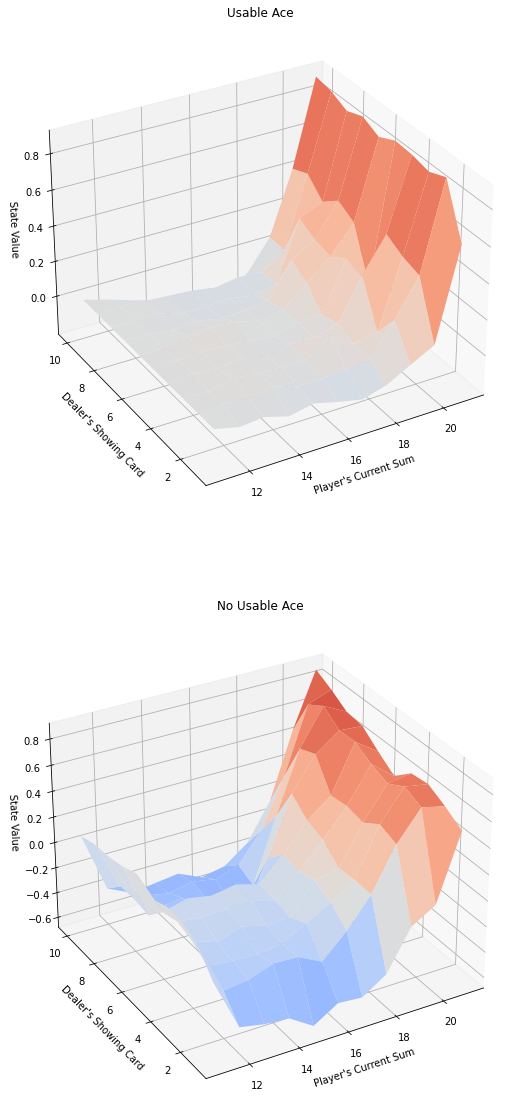

In [51]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q_sarsa .items())

# plot the state-value function
plot_blackjack_values(V)

### III. Expexted SARSA

Episode 500000/500000

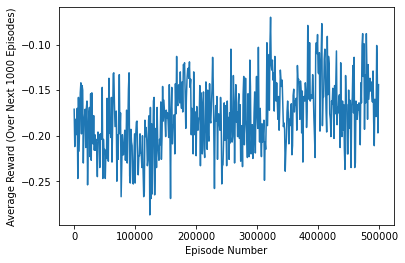

Best Average Reward over 1000 Episodes:  -0.07


In [272]:
policy_expsarsa,Q_expsarsa,score_expsarsa = expected_sarsa(env, 500000, 1,plot_every=1000)

In [252]:
expsarsa_score = win_draw_rate(score_expsarsa)

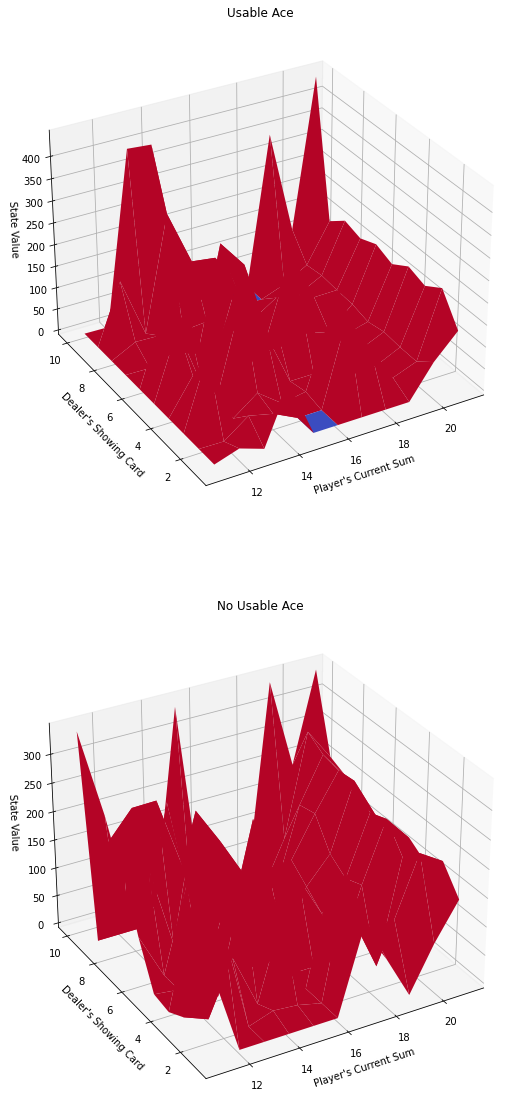

In [118]:
V = dict((k,np.max(v)) for k, v in Q_expsarsa.items())

plot_blackjack_values(V)

### IV. Monte Carlo Exploring Start (ES)

Episode 500000/500000.

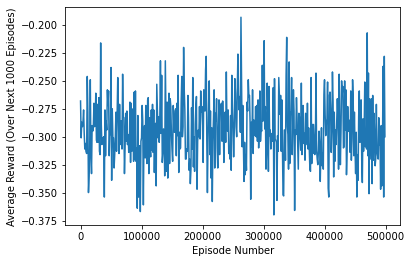

Best Average Reward over 1000 Episodes:  -0.193


In [274]:
policy_mc,Q_mc,score_mc = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic,plot_every=1000)

In [254]:
mc_score = win_draw_rate(score_mc)

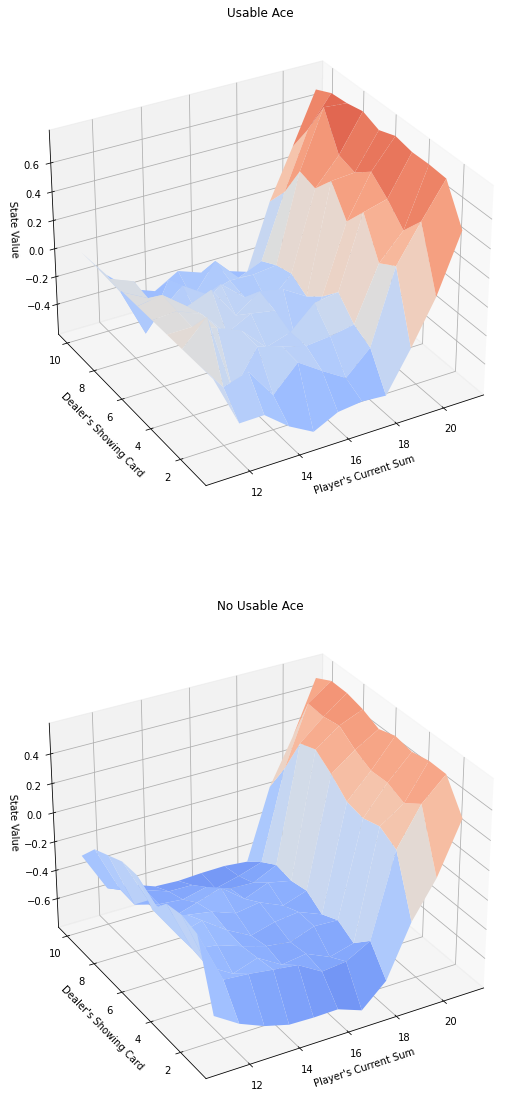

In [97]:
# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q_mc.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### IV. Monte Carlo Control

Episode 500000/500000.

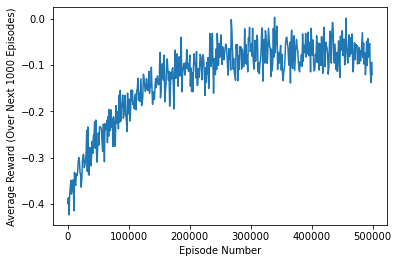

Best Average Reward over 1000 Episodes:  0.003


In [273]:
policy_mcc, Q_mcc,score_mcc = mc_control(env, 500000, 0.02,plot_every=1000)

In [266]:
mcc_score = win_draw_rate(score_mcc)

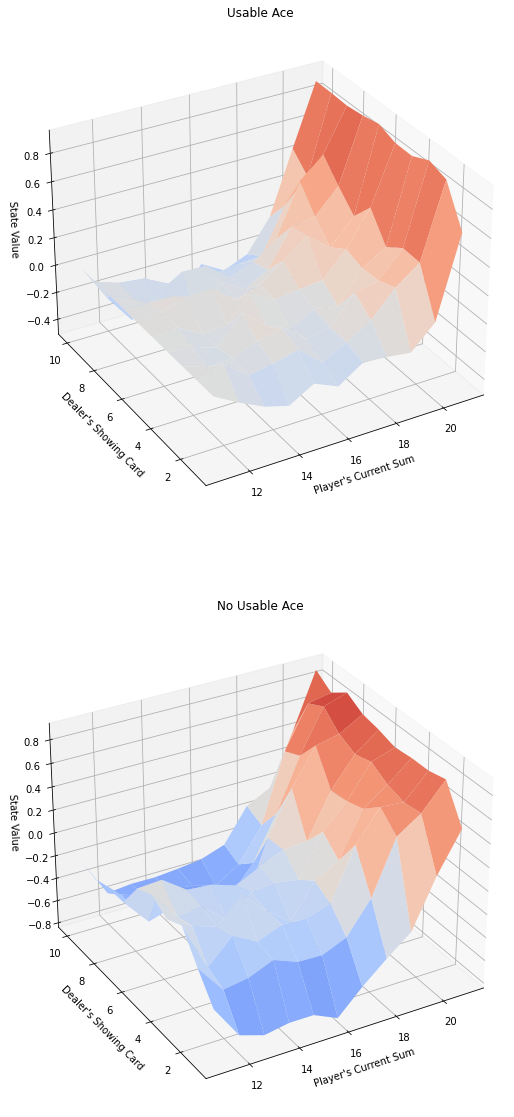

In [87]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q_mcc.items())

# plot the state-value function
plot_blackjack_values(V)

## Policy Results
### Q-Learning

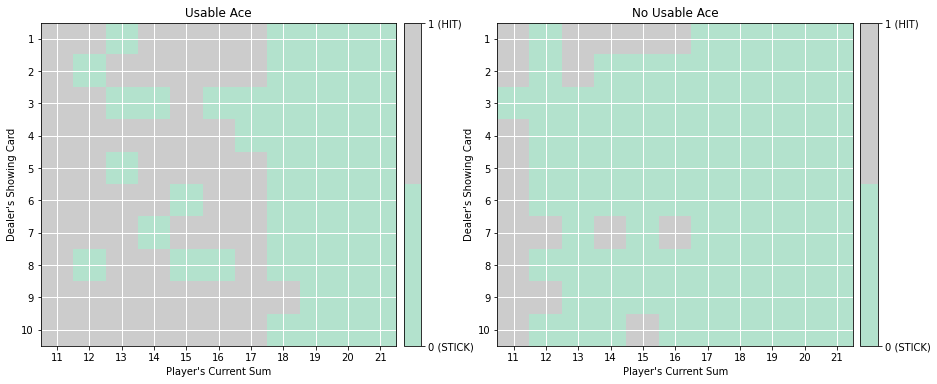

In [132]:
plot_policy(policy_mcc)

### SARSA

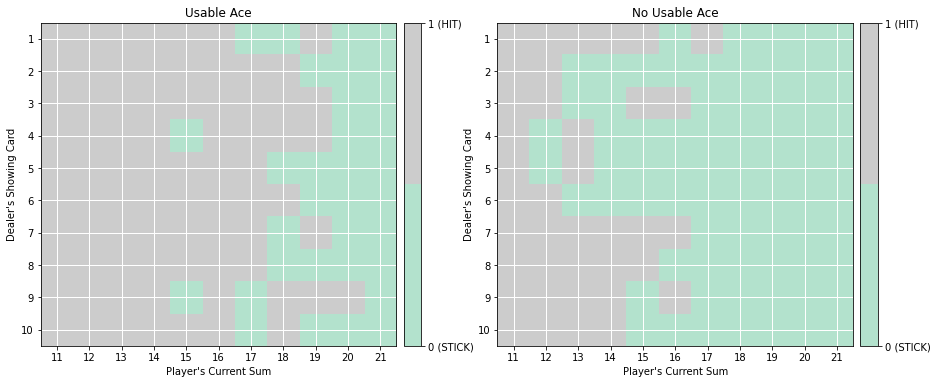

In [133]:
plot_policy(policy_sarsa)

## Expected SARSA

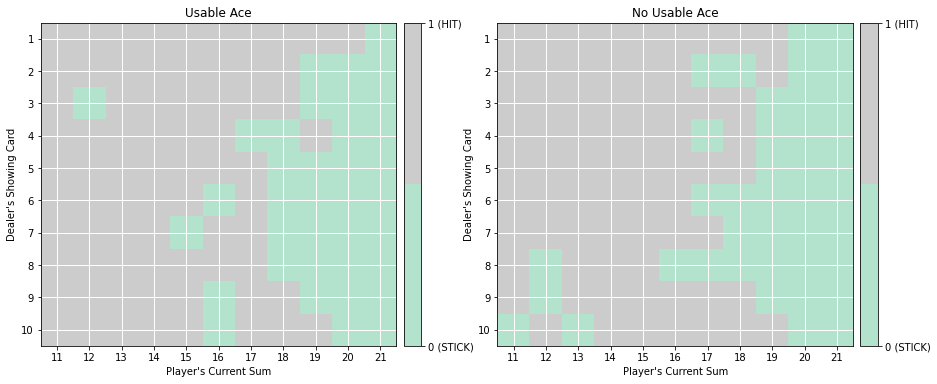

In [134]:
plot_policy(policy_expsarsa)

## Monte Carlo Exploring Start (ES)

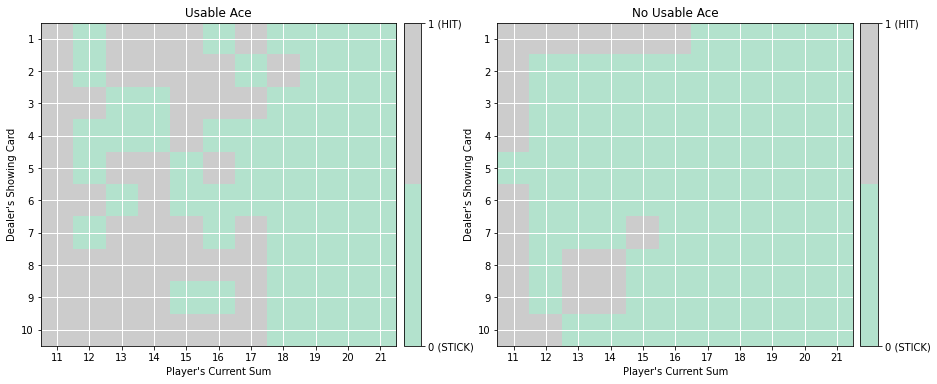

In [135]:
plot_policy(policy_mc)

## Monte Carlo Control

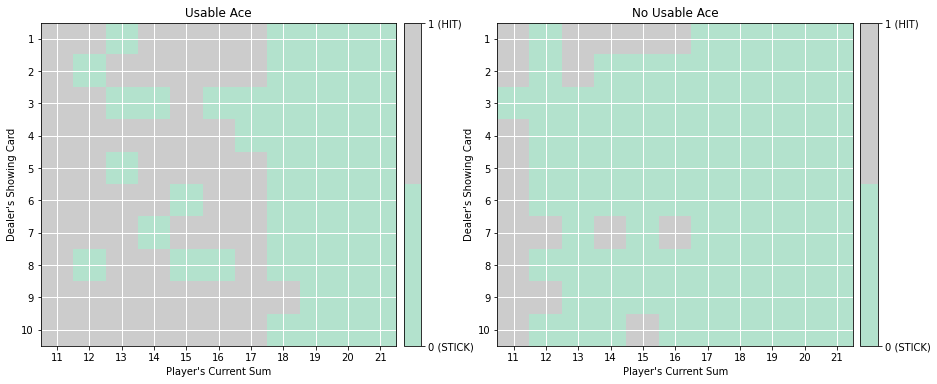

In [136]:
plot_policy(policy_mcc)

## Results 

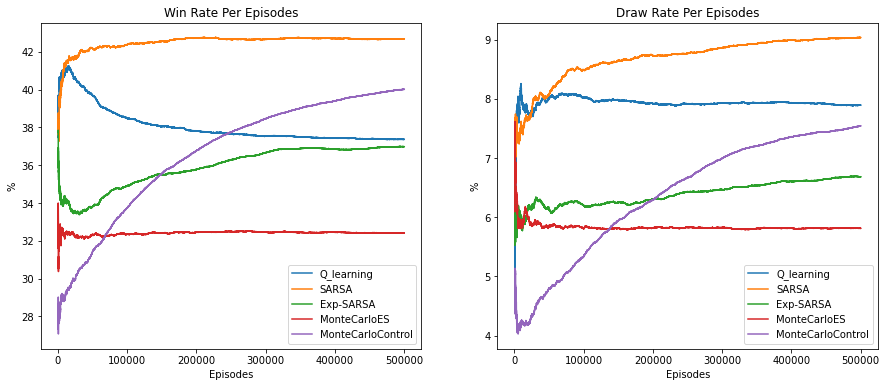

In [268]:
n = 500
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.plot(Q_score['win_rate'][n:],label='Q_learning')
ax1.plot(sarsa_score['win_rate'][n:],label='SARSA')
ax1.plot(expsarsa_score['win_rate'][n:],label='Exp-SARSA')
ax1.plot(mc_score['win_rate'][n:],label='MonteCarloES')
ax1.plot(mcc_score['win_rate'][n:],label='MonteCarloControl')
ax1.legend()
ax1.set_ylabel('%')
ax1.set_xlabel('Episodes')
ax1.set_title('Win Rate Per Episodes')
ax2.plot(Q_score['draw_rate'][n:],label='Q_learning')
ax2.plot(sarsa_score['draw_rate'][n:],label='SARSA')
ax2.plot(expsarsa_score['draw_rate'][n:],label='Exp-SARSA')
ax2.plot(mc_score['draw_rate'][n:],label='MonteCarloES')
ax2.plot(mcc_score['draw_rate'][n:],label='MonteCarloControl')
ax2.legend()
ax2.set_ylabel('%')
ax2.set_title('Draw Rate Per Episodes')
ax2.set_xlabel('Episodes')
plt.show()